<a href="https://colab.research.google.com/github/markomiz/ML-paths/blob/main/maze_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

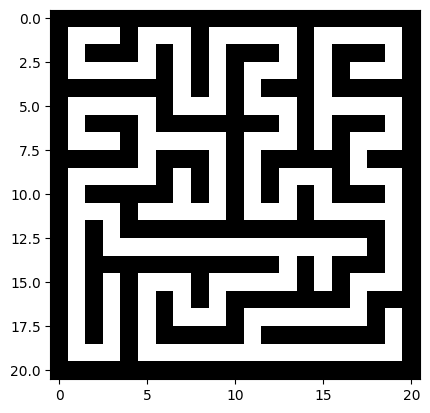

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Maze creation using Recursive Backtracking
def create_maze(width, height):
    maze = np.zeros((height, width), dtype=np.uint8)
    maze[1::2, 1::2] = 0
    return maze

def carve_passages_from(cx, cy, maze):
    directions = [(0, 2), (2, 0), (0, -2), (-2, 0)]
    random.shuffle(directions)
    for direction in directions:
        nx, ny = cx + direction[0], cy + direction[1]
        if 1 <= nx < maze.shape[1]-1 and 1 <= ny < maze.shape[0]-1 and maze[ny, nx] == 0:
            maze[cy + direction[1]//2, cx + direction[0]//2] = 1
            maze[ny, nx] = 1
            carve_passages_from(nx, ny, maze)

def generate_unique_maze(width, height):
    maze = create_maze(width, height)
    carve_passages_from(1, 1, maze)
    return maze

# Test the maze generation
width, height = 21, 21
unsolved_maze = generate_unique_maze(width, height)

plt.imshow(unsolved_maze, cmap='gray')
plt.show()



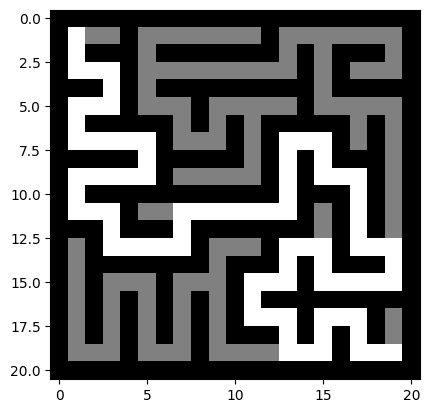

In [ ]:
import heapq

def dijkstra(maze):
    height, width = maze.shape
    start, goal = (1, 1), (height-2, width-2)
    queue = [(0, start)]
    distances = {start: 0}
    parents = {start: None}
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]

    while queue:
        current_distance, current_cell = heapq.heappop(queue)

        if current_cell == goal:
            break

        for direction in directions:
            neighbor = (current_cell[0] + direction[0], current_cell[1] + direction[1])

            if 0 <= neighbor[0] < height and 0 <= neighbor[1] < width and maze[neighbor] == 1:
                distance = current_distance + 1

                if distance < distances.get(neighbor, float('inf')):
                    distances[neighbor] = distance
                    priority = distance
                    heapq.heappush(queue, (priority, neighbor))
                    parents[neighbor] = current_cell

    path = []
    step = goal
    while step is not None:
        path.append(step)
        step = parents[step]
    path.reverse()

    return path

solved_path = dijkstra(unsolved_maze)

solved_maze = unsolved_maze *1

for y, x in solved_path:
    solved_maze[y, x] = 2

plt.imshow(solved_maze, cmap='gray')
plt.show()


In [ ]:
def save_maze_image(maze, path, filename):
    solved_maze = maze.copy()
    for y, x in path:
        solved_maze[y, x] = 2
    solved_maze[solved_maze < 2] = 0
    plt.imsave(filename, solved_maze, cmap='gray')

save_maze_image(unsolved_maze, solved_path, 'solved_maze.png')


In [ ]:
import os
from PIL import Image

def generate_dataset(num_mazes, width, height, dataset_dir):
    os.makedirs(dataset_dir, exist_ok=True)
    os.makedirs(os.path.join(dataset_dir, 'unsolved'), exist_ok=True)
    os.makedirs(os.path.join(dataset_dir, 'solved'), exist_ok=True)

    for i in range(num_mazes):
        unsolved_maze = generate_unique_maze(width, height)
        solved_path = dijkstra(unsolved_maze)

        unsolved_filename = os.path.join(dataset_dir, 'unsolved', f'unsolved_{i}.png')
        solved_filename = os.path.join(dataset_dir, 'solved', f'solved_{i}.png')

        Image.fromarray(unsolved_maze * 255).save(unsolved_filename)
        save_maze_image(unsolved_maze, solved_path, solved_filename)

generate_dataset(1000, width, height, 'maze_dataset')


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image


class MazeDataset(Dataset):
    def __init__(self, unsolved_dir, solved_dir, transform=None):
        self.unsolved_dir = unsolved_dir
        self.solved_dir = solved_dir
        self.transform = transform
        self.filenames = [f for f in os.listdir(unsolved_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        unsolved_image_path = os.path.join(self.unsolved_dir, self.filenames[idx])
        solved_image_path = os.path.join(self.solved_dir, self.filenames[idx].replace('unsolved', 'solved'))

        unsolved_image = Image.open(unsolved_image_path).convert("L")
        solved_image = Image.open(solved_image_path).convert("L")

        if self.transform:
            unsolved_image = self.transform(unsolved_image)
            solved_image = self.transform(solved_image)

        return unsolved_image, solved_image

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((width, height)),
    transforms.ToTensor()
])

# Create the dataset and dataloader
train_dataset = MazeDataset('maze_dataset/unsolved', 'maze_dataset/solved', transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


class MazeSolverCNN(nn.Module):
    def __init__(self):
        super(MazeSolverCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, width * height)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = F.max_pool2d(F.relu(self.conv4(x)), 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(x.size(0), 1, width, height)
        return x

model = MazeSolverCNN()


In [ ]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 200
losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for unsolved, solved in train_loader:
        optimizer.zero_grad()
        outputs = model(unsolved)
        loss = criterion(outputs, solved)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    torch.save({
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'losses': losses,
      }, 'maze_solver.pth')


Epoch [1/200], Loss: 0.1158
Epoch [2/200], Loss: 0.0948
Epoch [3/200], Loss: 0.0836
Epoch [4/200], Loss: 0.0735
Epoch [5/200], Loss: 0.0638
Epoch [6/200], Loss: 0.0553
Epoch [7/200], Loss: 0.0487
Epoch [8/200], Loss: 0.0432
Epoch [9/200], Loss: 0.0384
Epoch [10/200], Loss: 0.0347
Epoch [11/200], Loss: 0.0311
Epoch [12/200], Loss: 0.0290
Epoch [13/200], Loss: 0.0268
Epoch [14/200], Loss: 0.0252
Epoch [15/200], Loss: 0.0226
Epoch [16/200], Loss: 0.0207
Epoch [17/200], Loss: 0.0191
Epoch [18/200], Loss: 0.0177
Epoch [19/200], Loss: 0.0166
Epoch [20/200], Loss: 0.0156
Epoch [21/200], Loss: 0.0150
Epoch [22/200], Loss: 0.0146
Epoch [23/200], Loss: 0.0142
Epoch [24/200], Loss: 0.0139
Epoch [25/200], Loss: 0.0134
Epoch [26/200], Loss: 0.0126
Epoch [27/200], Loss: 0.0122
Epoch [28/200], Loss: 0.0123
Epoch [29/200], Loss: 0.0115
Epoch [30/200], Loss: 0.0105
Epoch [31/200], Loss: 0.0101
Epoch [32/200], Loss: 0.0099
Epoch [33/200], Loss: 0.0097
Epoch [34/200], Loss: 0.0092
Epoch [35/200], Loss: 0

In [ ]:
checkpoint = torch.load('maze_solver.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
losses = checkpoint['losses']


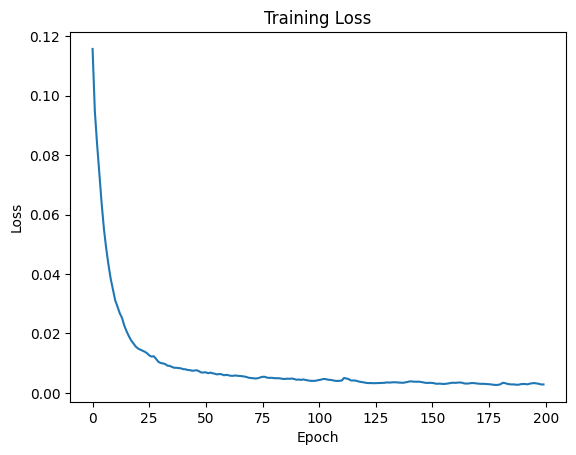

In [ ]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


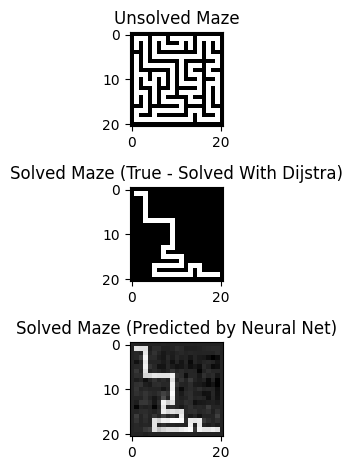

In [ ]:
test_dataset = MazeDataset('maze_dataset/unsolved', 'maze_dataset/solved', transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

model.eval()
with torch.no_grad():
    for unsolved, solved in test_loader:
        output = model(unsolved)
        plt.figure()
        plt.subplot(3, 1, 1)
        plt.title('Unsolved Maze')
        plt.imshow(unsolved.squeeze().numpy(), cmap='gray')
        plt.subplot(3, 1, 2)
        plt.title('Solved Maze (True - Solved With Dijstra)')
        plt.imshow(solved.squeeze().numpy(), cmap='gray')
        plt.subplot(3, 1, 3)
        plt.title('Solved Maze (Predicted by Neural Net)')
        plt.imshow(output.squeeze().numpy(), cmap='gray')
        plt.tight_layout()
        plt.show()
        break
